In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from skorch.callbacks import EpochScoring
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import PCA


In [2]:
data = pd.read_csv("./train.csv")
subspures = pd.read_csv("./substances.csv")
pure_heroin = subspures[(subspures['substance'] == 'heroin (white)') | (subspures["substance"]=="heroin (brown)")]

In [6]:
data_new_features2 = data.iloc[:, 6:].values.dot(subspures.iloc[:,1:].values.T)
data_new_features2 = pd.DataFrame(data_new_features2, columns = subspures["substance"])

#spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
#spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)

X = data_new_features2
y = data["PURITY"]

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train)
X_valid_standardized = standardizer.transform(X_valid)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)

In [7]:

# Définir le modèle de réseau de neurones simple
class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features=50, fc2_out_features=1, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_out_features)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(fc2_out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Définir la classe NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, eta=0.001, max_epochs=100, fc1_out_features=50, fc2_out_features=1, batch=10, dropout_rate = 0.5):
        self.input_size = input_size
        self.eta = eta
        self.max_epochs = max_epochs
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.batch = batch
        self.dropout_rate = dropout_rate
        self.model = SimpleNN(input_size, fc1_out_features, fc2_out_features)
        self.criterion = nn.MSELoss()
    
    def fit(self, X, y):
        optimizer = optim.RMSprop(self.model.parameters(), lr=self.eta)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        for epoch in range(self.max_epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return outputs.numpy()
    
    def parameters(self):
        return self.model.parameters()

# Initialiser le modèle
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size)

# Définir les paramètres pour GridSearch
params = {
    'eta': [0.005, 0.001, 0.01],
    'max_epochs': [90],
    'fc1_out_features': [32, 64, 128],
    'fc2_out_features': [32, 64, 128],
    'batch': [45, 50],
    'dropout_rate': [0.9, 0.7]
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(net, params, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=0)

# Entraîner le modèle avec GridSearch
grid_result = grid_search.fit(X_train_tensor, y_train_tensor)
nouveau_model = grid_result.best_estimator_

print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
criterion = nn.MSELoss()
batch_size = grid_result.best_params_["batch"]
batches_per_epoch = len(X_train_tensor) // batch_size

# Entraîner le modèle avec la descente de gradient
def gradient_descent(model, criterion, X_train_tensor, y_train_tensor, eta=0.01, n_epochs=100, batch_size=10):
    optimizer = optim.RMSprop(model.parameters(), lr=eta)
    learning_curve = []
    steps = []
    batches_per_epoch = len(X_train_tensor) // batch_size
    
    for epoch in range(n_epochs):
        for i in range(batches_per_epoch):
            start = i * batch_size
            end = start + batch_size
            Xbatch = X_train_tensor[start:end]
            ybatch = y_train_tensor[start:end]

            # Forward pass
            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            learning_curve.append(loss.item())
            steps.append(epoch * batches_per_epoch + i + 1)
        
            # Vérifiez les pertes pendant l'entraînement
            if torch.isnan(loss).any().item():
                print(f"NaN loss detected at epoch {epoch}, batch {i}")
    
    return model, learning_curve, steps

# Entraîner le modèle avec la descente de gradient
model, learning_curve, steps = gradient_descent(nouveau_model.model, criterion, X_train_tensor, y_train_tensor, eta=grid_result.best_params_["eta"], n_epochs=grid_result.best_params_["max_epochs"], batch_size=batch_size)

/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_11487/381367139.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_11487/381367139.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32)
/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_11487/381367139.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/var/folders/93/

Best MSE: -462.818707 using {'batch': 45, 'dropout_rate': 0.7, 'eta': 0.01, 'fc1_out_features': 64, 'fc2_out_features': 128, 'max_epochs': 90}


X_valid_tensor contains NaN: False
y_valid_tensor contains NaN: False
y_pred contains NaN: False
MSE : 113.87096
t_score test : 0.4923076927661896
t_score train : 0.48365384340286255


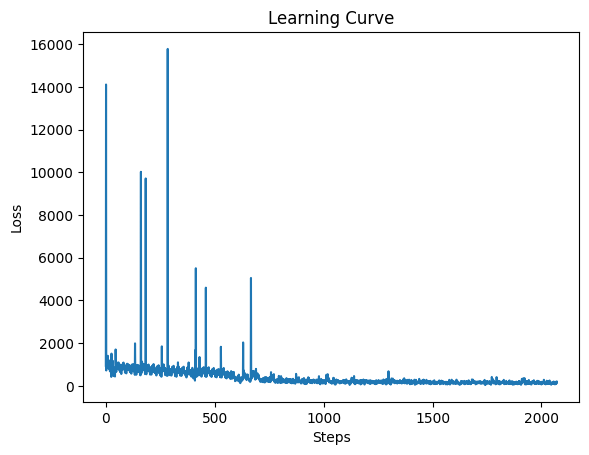

In [8]:
# Vérifiez les données d'entrée
print("X_valid_tensor contains NaN:", torch.isnan(X_valid_tensor).any().item())
print("y_valid_tensor contains NaN:", torch.isnan(y_valid_tensor).any().item())

# Générer les prédictions sur les données de validation
model.eval()
with torch.no_grad():
    y_pred = model(X_valid_tensor).detach().numpy()
    y_pred_train = model(X_train_tensor).detach().numpy()

# Vérifiez les sorties du modèle
print("y_pred contains NaN:", np.isnan(y_pred).any())

# Calculer la MSE
mse = np.mean((y_pred - y_valid_tensor.numpy())**2)
print("MSE :", mse)

# Calculer le t_score
predictions_tensor = torch.tensor(y_pred, dtype=torch.float32)
predictions_tensor_train = torch.tensor(y_pred_train, dtype=torch.float32)
t_score_test = torch.mean((torch.abs(predictions_tensor - y_valid_tensor) <= 5).float())
t_score_train = torch.mean((torch.abs(predictions_tensor_train - y_train_tensor) <= 5).float())
print("t_score test :", t_score_test.item())
print("t_score train :", t_score_train.item())

# Afficher la courbe d'apprentissage
import matplotlib.pyplot as plt
plt.plot(steps, learning_curve)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()